# Hyper-parameter optimization

Evaluated on smaller subset of the available features.

In the repo a syntetical data (generated by a special GAN) is available to test the notebook. 

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [3]:
# tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import AlphaDropout
from tensorflow.keras import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam

# sklearn
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [2]:
# hyperas
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


ModuleNotFoundError: No module named 'hyperopt'

In [2]:
tf.test.is_gpu_available(cuda_only=True,
    min_cuda_compute_capability=None
)

True

## Hyperparameter-optimization with hyperas

In [2]:
def data():
    featuretype = pd.read_csv('feature_types.csv', sep=';')
    df_imp_wonan_dumm2 = pd.read_csv('data_clean_onehot_real.csv', sep=';')

    # preprocess
    df_imp_wonan_dumm = df_imp_wonan_dumm2.sample(frac=1)
    dataset = df_imp_wonan_dumm.values
    # test and validation ratio
    test_step = .1
    valid_step = .1

    # features and output
    X = dataset[:,0:-1]
    Y = dataset[:,-1]

    # indexing
    valid_index = int(X.shape[0]*(1-valid_step-test_step))
    test_index = int(X.shape[0]*(1-test_step))

    # test split
    X_test = X[test_index:]
    Y_test = Y[test_index:]
    #Y_test = to_categorical(Y[test_index:],2)

    # validation split
    X_valid = X[valid_index:test_index]
    Y_valid = Y[valid_index:test_index]
    #Y_valid = to_categorical(Y[valid_index:test_index],2)

    # training split
    X_train = X[:test_index]
    Y_train = Y[:test_index]
    #Y_train = to_categorical(Y[:test_index],2)


    # MinMax scaling

    scaler = MinMaxScaler(feature_range=(0, 1)).fit(X_train)
    x_train = scaler.transform(X_train)
    x_test = scaler.transform(X_test)
    x_valid = scaler.transform(X_valid)
    y_train = Y_train.astype(int)
    y_test = Y_test.astype(int)
    y_valid = Y_valid.astype(int)
    return x_train, Y_train, x_test, Y_test

In [4]:
# log kiírása fájlba
with open('hyperas-log.csv', 'w') as csv_file:
    csv_file.write('depth' + ';')
    csv_file.write('activ' + ';')
    csv_file.write('dens_size' + ';')
    csv_file.write('bn_or_drop' + ';')
    csv_file.write('drop_rate' + ';')
    csv_file.write('kernin' + ';')
    csv_file.write('optim' + ';')
    csv_file.write('n_batch' + ';')
    csv_file.write('train_acc' + ';')
    csv_file.write('validation_acc' + '\n')

def create_model(x_train, Y_train, x_test, Y_test):
    
    kernin = {{choice(['glorot_normal', 'glorot_uniform',
                       'unif_pmone', 'justones'])}}
    if kernin == 'unif_pmone':
        kernin_o = tf.keras.initializers.RandomUniform(-1,1)
    elif kernin == 'justones':
        kernin_o = tf.keras.initializers.Ones()
    else:
        kernin_o = kernin
        
    depth = {{choice([1,2,3,4,5,6,7,8,9,10])}}
    activ = {{choice(['relu', 'sigmoid', 'selu'])}}
    dens_size= {{choice([16, 24, 32, 40])}}
    bn_or_drop= {{choice(['BN','drop', 'alphadrop'])}}
    drop_rate= 0
    
    model = Sequential()
    model.add(Dense(dens_size,
                    activation=activ,
                    kernel_initializer=kernin_o, input_shape=(x_train.shape[1],)))
    for i in range(depth):
        if bn_or_drop == 'BN':
            model.add(BatchNormalization())
        elif bn_or_drop == 'drop':
            drop_rate = {{uniform(0, 0.5)}}
            model.add(Dropout(drop_rate))
        else:
            drop_rate = {{uniform(0, 0.5)}}
            model.add(AlphaDropout(drop_rate))
            
        model.add(Dense(dens_size,
                        activation=activ,
                        kernel_initializer=kernin_o))
    model.add(Dense(1, activation='sigmoid', kernel_initializer=kernin_o))
    
    optim = {{choice(['adam', 'sgd', 'rmsprop', 'sgd_point1', 'sgd_1'])}}
    if optim == 'sgd_1':
        optim_o = SGD(learning_rate=1)
    elif optim == 'sgd_point1':
        optim_o = SGD(learning_rate=.1)
    else:
        optim_o = optim
    model.compile(optimizer=optim_o,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    n_batch = {{choice([16, 32, 64, 128])}}
    result = model.fit(x_train,Y_train,
                       batch_size=n_batch,
                       epochs=30,
                       verbose=0,
                       shuffle=True,
                       validation_data=(x_test, Y_test))
    
    validation_acc = np.amax(result.history['val_acc'])
    train_acc = np.amax(result.history['acc']) 
    print('Best validation acc of epoch:', validation_acc)
    print('Best train acc of epoch:', train_acc)
    
    # log into file
    with open('hyperas-log.csv', 'a') as csv_file:
        csv_file.write(str(depth) + ';')
        csv_file.write(str(activ) + ';')
        csv_file.write(str(dens_size) + ';')
        csv_file.write(str(bn_or_drop) + ';')
        csv_file.write(str(drop_rate) + ';')
        csv_file.write(str(kernin) + ';')
        csv_file.write(str(optim) + ';')
        csv_file.write(str(n_batch) + ';')
        csv_file.write(str(train_acc) + ';')
        csv_file.write(str(validation_acc) + '\n')
    
    return {'loss': -validation_acc, 'status': STATUS_OK, 'model': model}

best_run, best_model = optim.minimize(model=create_model,
                                      data=data,
                                      algo=tpe.suggest,
                                      max_evals=300,
                                      notebook_name='models_and_interpretability_milestone2',
                                      trials=Trials(),
                                      keep_temp=True)

x_train, Y_train, x_test, Y_test = data()
print("Evalutation of best performing model:")
print(best_model.evaluate(x_test, Y_test))
print("Best performing model chosen hyper-parameters:")
print(best_run)

>>> Imports:
#coding=utf-8

try:
    import tensorflow as tf
except:
    pass

try:
    import pandas as pd
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    from sklearn.preprocessing import StandardScaler
except:
    pass

try:
    from sklearn.preprocessing import MinMaxScaler
except:
    pass

try:
    import shap
except:
    pass

try:
    import lime
except:
    pass

try:
    import eli5
except:
    pass

try:
    from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
except:
    pass

try:
    from tensorflow.keras.layers import AlphaDropout
except:
    pass

try:
    from tensorflow.keras import Model
except:
    pass

try:
    from tensorflow.keras.utils import to_categorical
except:
    pass

try:
    from tensorflow.keras.models import Sequential
except:
    pass

try:
    from tensorflow.keras.optimizers import SGD, Adam
except:
    pass

try:
    from tensorflow.keras.wrapper

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Best validation acc of epoch:                        
0.5330882                                            
Best train acc of epoch:                             
0.51125205                                           
Best validation acc of epoch:                                                   
0.74080884                                                                      
Best train acc of epoch:                                                        
0.6650982                                                                       
Best validation acc of epoch:                                                    
0.74264705                                                                       
Best train acc of epoch:                                                         
0.6779869                                                                        
Best validation acc of epoch:         

0.66448444                                                                        
Best validation acc of epoch:                                                     
0.5349265                                                                         
Best train acc of epoch:                                                          
0.53600657                                                                        
Best validation acc of epoch:                                                     
0.5055147                                                                         
Best train acc of epoch:                                                          
0.5220949                                                                         
Best validation acc of epoch:                                                     
0.7463235                                                                         
Best train acc of epoch:                                                          
0.72

0.72610295                                                                          
Best train acc of epoch:                                                            
0.6499591                                                                           
Best validation acc of epoch:                                                       
0.5036765                                                                           
Best train acc of epoch:                                                            
0.5204583                                                                           
Best validation acc of epoch:                                                       
0.7463235                                                                           
Best train acc of epoch:                                                            
0.67164487                                                                          
Best validation acc of epoch:                                    

0.67512274                                                                           
Best validation acc of epoch:                                                         
0.74264705                                                                            
Best train acc of epoch:                                                              
0.6898527                                                                             
Best validation acc of epoch:                                                         
0.7463235                                                                             
Best train acc of epoch:                                                              
0.6812602                                                                             
Best validation acc of epoch:                                                         
0.74264705                                                                            
Best train acc of epoch:                    

0.66693944                                                                            
Best validation acc of epoch:                                                         
0.74080884                                                                            
Best train acc of epoch:                                                              
0.7041735                                                                             
Best validation acc of epoch:                                                         
0.5036765                                                                             
Best train acc of epoch:                                                              
0.5135025                                                                             
Best validation acc of epoch:                                                         
0.50919116                                                                            
Best train acc of epoch:                   

0.70478725                                                                            
Best validation acc of epoch:                                                         
0.72794116                                                                            
Best train acc of epoch:                                                              
0.64648116                                                                            
Best validation acc of epoch:                                                         
0.5036765                                                                             
Best train acc of epoch:                                                              
0.5159575                                                                             
Best validation acc of epoch:                                                         
0.7297794                                                                             
Best train acc of epoch:                   

0.66693944                                                                            
Best validation acc of epoch:                                                         
0.5036765                                                                           
Best train acc of epoch:                                                            
0.4928396                                                                           
Best validation acc of epoch:                                                       
0.5514706                                                                           
Best train acc of epoch:                                                            
0.5196399                                                                           
Best validation acc of epoch:                                                       
0.7224265                                                                           
Best train acc of epoch:                                     

In [30]:
tf.keras.models.save_model(best_model, "hyperas_bestmodel.hdf5")

In [3]:
hyperas_log = pd.read_csv('hyperas-log.csv', delimiter=';')

In [4]:
hyperas_log['acc'] = (x_train.shape[0] * hyperas_log['train_acc'] + 
                      x_valid.shape[0] * hyperas_log['validation_acc']) / (x_train.shape[0] + x_valid.shape[0]) 

In [22]:
hyperas_best10 = hyperas_log.sort_values(by=['validation_acc'], ascending=False).head(n=10)
hyperas_best10

,depth,activ,dens_size,bn_or_drop,drop_rate,kernin,optim,n_batch,train_acc,validation_acc,acc
72,6,relu,40,drop,0.323870,glorot_normal,rmsprop,16,0.683715,0.757353,0.691080
276,6,selu,24,drop,0.439248,glorot_uniform,adam,16,0.668167,0.755515,0.676903
277,6,selu,24,drop,0.449593,glorot_uniform,adam,16,0.668167,0.755515,0.676903
280,6,selu,24,drop,0.465648,glorot_uniform,adam,16,0.666121,0.755515,0.675062
206,6,selu,24,drop,0.405714,glorot_uniform,adam,16,0.673895,0.753677,0.681875
26,2,selu,40,drop,0.356342,glorot_normal,rmsprop,16,0.685147,0.753677,0.692001
77,6,relu,24,drop,0.271733,glorot_uniform,adam,32,0.684738,0.753677,0.691633
130,3,selu,24,drop,0.239673,glorot_uniform,rmsprop,16,0.687398,0.751838,0.693843
278,6,selu,24,drop,0.445732,glorot_uniform,adam,16,0.673486,0.751838,0.681323
64,4,relu,40,drop,0.266409,glorot_normal,rmsprop,32,0.694149,0.751838,0.699919


In [23]:
hyperas_worst10 = hyperas_log.sort_values(by=['validation_acc'], ascending=False).tail(n=10)
hyperas_worst10

,depth,activ,dens_size,bn_or_drop,drop_rate,kernin,optim,n_batch,train_acc,validation_acc,acc
232,6,relu,32,alphadrop,0.411168,justones,sgd_point1,16,0.509002,0.503677,0.508469
256,10,sigmoid,32,drop,0.263330,glorot_normal,rmsprop,16,0.510843,0.503677,0.510126
207,6,sigmoid,24,drop,0.477629,glorot_uniform,adam,64,0.515753,0.503677,0.514545
209,10,selu,32,drop,0.390293,justones,adam,16,0.492635,0.503677,0.493739
98,6,sigmoid,40,alphadrop,0.141667,glorot_uniform,sgd_point1,64,0.520458,0.503677,0.518780
6,9,relu,24,drop,0.378592,glorot_normal,sgd_point1,128,0.584697,0.496324,0.575858
120,7,relu,40,drop,0.407672,glorot_normal,sgd,64,0.534574,0.496324,0.530749
296,6,sigmoid,24,alphadrop,0.308795,glorot_uniform,adam,128,0.510025,0.496324,0.508654
219,9,selu,32,drop,0.355762,justones,sgd_1,64,0.507365,0.496324,0.506261
19,10,relu,16,alphadrop,0.005850,glorot_normal,sgd,64,0.512480,0.496324,0.510864


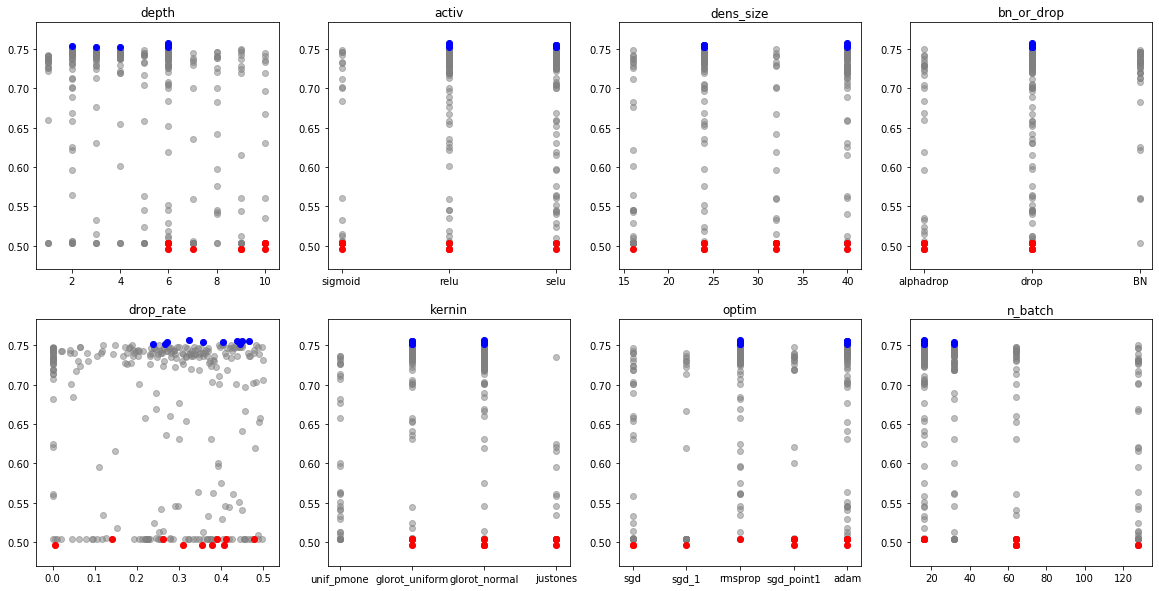

In [35]:
%matplotlib inline
hyperas_best10 = hyperas_log.sort_values(by=['validation_acc'], ascending=False).head(n=10)
hyperas_worst10 = hyperas_log.sort_values(by=['validation_acc'], ascending=False).tail(n=10)
plt.figure(figsize=(20,10))
for i, hyperparam in enumerate(['depth','activ','dens_size', 'bn_or_drop', 'drop_rate',
                                'kernin','optim','n_batch']):
    plt.subplot(2,4,i+1)
    plt.scatter(x=hyperas_log[hyperparam], y=hyperas_log['validation_acc'], c="gray", alpha=.5)
    plt.scatter(x=hyperas_best10[hyperparam], y=hyperas_best10['validation_acc'], c='blue')
    plt.scatter(x=hyperas_worst10[hyperparam], y=hyperas_worst10['validation_acc'], c='red')
    plt.title(hyperparam)
plt.savefig('hyperas_val.pdf', bbox_inches='tight')
plt.show()

In [31]:
hyperas_log = pd.read_csv('hyperas-log.csv', delimiter=';')
hyperas_best10 = hyperas_log.sort_values(by=['train_acc'], ascending=False).head(n=10)
hyperas_best10

,depth,activ,dens_size,bn_or_drop,drop_rate,kernin,optim,n_batch,train_acc,validation_acc
138,5,relu,32,BN,0.0,glorot_normal,rmsprop,128,0.781915,0.733456
113,6,relu,40,BN,0.0,glorot_normal,adam,64,0.772300,0.720588
198,4,relu,40,BN,0.0,glorot_normal,rmsprop,32,0.752046,0.746323
177,2,relu,40,BN,0.0,glorot_normal,sgd_1,128,0.739975,0.713235
39,3,selu,40,BN,0.0,unif_pmone,rmsprop,64,0.730769,0.713235
241,6,selu,24,BN,0.0,glorot_normal,adam,128,0.730565,0.729779
101,5,selu,40,BN,0.0,glorot_uniform,rmsprop,32,0.728723,0.744485
51,4,selu,40,BN,0.0,glorot_uniform,rmsprop,32,0.728110,0.746323
299,6,selu,24,BN,0.0,glorot_uniform,adam,128,0.726064,0.726103
213,8,selu,24,BN,0.0,glorot_uniform,adam,64,0.722177,0.746323


In [32]:
hyperas_worst10 = hyperas_log.sort_values(by=['train_acc'], ascending=False).tail(n=10)
hyperas_worst10

,depth,activ,dens_size,bn_or_drop,drop_rate,kernin,optim,n_batch,train_acc,validation_acc
183,2,selu,32,drop,0.226095,justones,sgd,128,0.492635,0.503677
92,9,relu,16,drop,0.278731,unif_pmone,sgd_1,64,0.492635,0.503677
91,6,relu,32,drop,0.444425,justones,adam,16,0.492635,0.503677
209,10,selu,32,drop,0.390293,justones,adam,16,0.492635,0.503677
214,6,selu,32,drop,0.325304,justones,sgd_1,16,0.492635,0.503677
221,10,relu,16,drop,0.339663,unif_pmone,sgd_point1,16,0.492635,0.503677
224,6,selu,32,alphadrop,0.455112,justones,adam,16,0.492635,0.503677
231,9,selu,40,drop,0.386467,glorot_normal,sgd_1,64,0.492635,0.503677
76,6,relu,32,alphadrop,0.205154,unif_pmone,sgd_point1,16,0.492635,0.503677
106,10,selu,24,drop,0.226669,glorot_uniform,sgd_1,64,0.492635,0.503677


In [11]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    display(hyperas_log[hyperas_log['validation_acc']>=.7])

,depth,activ,dens_size,bn_or_drop,drop_rate,kernin,optim,n_batch,train_acc,validation_acc,acc
1,4,relu,32,drop,0.257640,glorot_uniform,sgd_1,64,0.665098,0.740809,0.672671
2,1,selu,40,drop,0.197497,glorot_normal,rmsprop,64,0.677987,0.742647,0.684454
5,2,selu,40,BN,0.000000,unif_pmone,rmsprop,128,0.719926,0.731618,0.721096
11,2,selu,32,drop,0.049615,glorot_normal,sgd,16,0.681465,0.740809,0.687400
13,9,relu,40,BN,0.000000,glorot_normal,adam,32,0.714812,0.727941,0.716125
16,4,relu,24,BN,0.000000,glorot_uniform,sgd,32,0.698445,0.718750,0.700476
20,1,selu,40,drop,0.467200,glorot_uniform,rmsprop,64,0.679010,0.737132,0.684823
23,2,selu,40,drop,0.191679,glorot_normal,rmsprop,16,0.690262,0.744485,0.695685
24,2,selu,40,drop,0.188686,glorot_normal,rmsprop,16,0.690262,0.750000,0.696237
25,2,selu,40,drop,0.191209,unif_pmone,rmsprop,16,0.626023,0.737132,0.637136


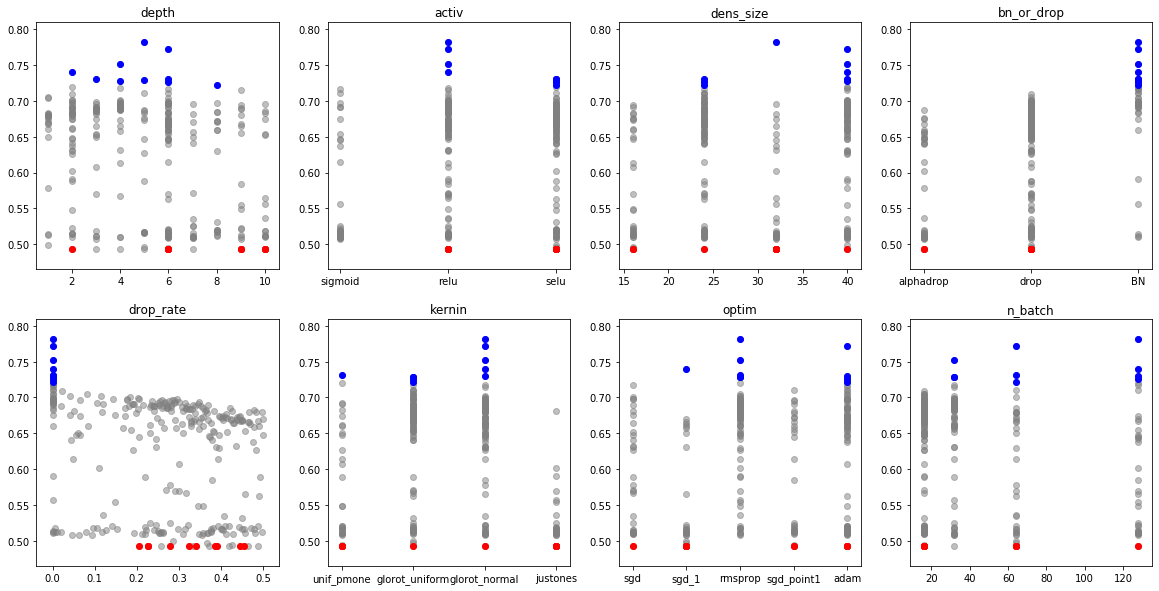

In [36]:
hyperas_best10 = hyperas_log.sort_values(by=['train_acc'], ascending=False).head(n=10)
hyperas_worst10 = hyperas_log.sort_values(by=['train_acc'], ascending=False).tail(n=10)
plt.figure(figsize=(20,10))
for i, hyperparam in enumerate(['depth','activ','dens_size', 'bn_or_drop', 'drop_rate',
                                'kernin','optim','n_batch']):
    plt.subplot(2,4,i+1)
    plt.scatter(x=hyperas_log[hyperparam],
                y=hyperas_log['train_acc'], c="gray", alpha=.5)
    plt.scatter(x=hyperas_best10[hyperparam],
                y=hyperas_best10['train_acc'], c='blue')
    plt.scatter(x=hyperas_worst10[hyperparam],
                y=hyperas_worst10['train_acc'], c='red')
    plt.title(hyperparam)
plt.savefig('hyperas_tra.pdf', bbox_inches='tight')
plt.show()

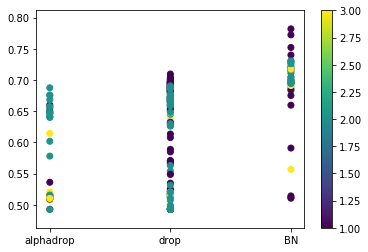

In [46]:
dd={'relu':1,'selu':2, 'sigmoid':3}
plt.scatter(x=hyperas_log['bn_or_drop'],
            y=hyperas_log['train_acc'],
            c=hyperas_log['activ'].map(dd), cmap='viridis')#, alpha=.5)
plt.colorbar()
#plt.title(hyperparam)
#plt.savefig('hyperas_tra.pdf', bbox_inches='tight')
plt.show()

In [11]:
hyperas_good=hyperas_log[(hyperas_log['acc']>=.7)]
hyperas_good

,depth,activ,dens_size,bn_or_drop,drop_rate,kernin,optim,n_batch,train_acc,validation_acc,acc
5,2,selu,40,BN,0.000000,unif_pmone,rmsprop,128,0.719926,0.731618,0.721096
13,9,relu,40,BN,0.000000,glorot_normal,adam,32,0.714812,0.727941,0.716125
16,4,relu,24,BN,0.000000,glorot_uniform,sgd,32,0.698445,0.718750,0.700476
36,10,selu,40,BN,0.000000,glorot_normal,rmsprop,16,0.696195,0.744485,0.701025
39,3,selu,40,BN,0.000000,unif_pmone,rmsprop,64,0.730769,0.713235,0.729015
51,4,selu,40,BN,0.000000,glorot_uniform,rmsprop,32,0.728110,0.746323,0.729931
57,3,selu,40,BN,0.000000,glorot_normal,sgd,16,0.697831,0.740809,0.702130
65,4,relu,40,drop,0.276216,glorot_normal,rmsprop,32,0.694967,0.748162,0.700288
66,4,relu,40,drop,0.288667,glorot_normal,rmsprop,32,0.696809,0.744485,0.701577
68,4,relu,40,drop,0.260811,glorot_normal,rmsprop,32,0.696604,0.744485,0.701393


In [14]:
hyperas_log["drop_rate_d"]=pd.cut(hyperas_log["drop_rate"], bins=5)

In [50]:
params=list(hyperas_log)[:4] + [list(hyperas_log)[-1]] + list(hyperas_log)[5:8]
step= -50
modes=pd.DataFrame(columns=list(range(300,0,step)), index=params)
for i in range(300,0,step):
    for c in params:
        modes.loc[c, i] = hyperas_log.tail(i)[c].mode()[0]
        #print(type(hyperas_log.tail(i)[c].mode()[0]))
    #print(hyperas_good[c].value_counts())
modes.to_latex("hyperas_modes.tex")